In [1]:

import numpy as np
from agent.dql import Agent
from environment.fogg_behavioural_model import Patient 
import matplotlib.pyplot as plt
from multiprocessing import Process, Pipe

In [2]:
import pickle
import cloudpickle

class CloudpickleWrapper(object):
	def __init__(self, x):
		self.x = x

	def __getstate__(self):
		return cloudpickle.dumps(self.x)

	def __setstate__(self, ob):
		self.x = pickle.loads(ob)
	
	def __call__(self):
		return self.x()

In [3]:
import numpy as np

class SubprocVecEnv():
	def __init__(self, env_fns):
		self.waiting = False
		self.closed = False
		no_of_envs = len(env_fns)
		self.remotes, self.work_remotes = \
			zip(*[Pipe() for _ in range(no_of_envs)])
		self.ps = []
		
		for wrk, rem, fn in zip(self.work_remotes, self.remotes, env_fns):
			proc = Process(target = worker, 
				args = (wrk, rem, CloudpickleWrapper(fn)))
			self.ps.append(proc)

		for p in self.ps:
			p.daemon = True
			p.start()

		for remote in self.work_remotes:
			remote.close()
	
	def step_async(self, actions):
		if self.waiting:
			raise AlreadySteppingError
		self.waiting = True

		for remote, action in zip(self.remotes, actions):
			remote.send(('step', action))
	
	def step_wait(self):
		if not self.waiting:
			raise NotSteppingError
		self.waiting = False

		results = [remote.recv() for remote in self.remotes]
		obs, rews, dones, infos = zip(*results)
		return np.stack(obs), np.stack(rews), np.stack(dones), info
	
	def step(self, actions):
		self.step_async(actions)
		return self.step_wait()
	
	def reset(self):
		for remote in self.remotes:
			remote.send(('reset', None))

		return np.stack([remote.recv() for remote in self.remotes])
	
	def close(self):
		if self.closed:
			return
		if self.waiting:
			for remote in self.remotes:
				remote.recv()
		for remote in self.remotes:
			remote.send(('close', None))
		for p in self.ps:
			p.join()
		self.closed = True

In [4]:
def worker(remote, parent_remote, env_fn):
	parent_remote.close()
	env = env_fn()
	while True:
		cmd, data = remote.recv()
		
		if cmd == 'step':
			ob, reward, done, info = env.step(data)
			if done:
				ob = env.reset()
			remote.send((ob, reward, done, info))

		elif cmd == 'render':
			remote.send(env.render())

		elif cmd == 'close':
			remote.close()
			break

		else:
			raise NotImplentedError

In [5]:
def make_mp_envs(env_id, num_env, seed, start_idx = 0):
	def make_env(rank):
		def fn():
			env = gym.make(env_id)
			env.seed(seed + rank)
			return env
		return fn
	return SubprocVecEnv([make_env(i + start_idx) for i in range(num_env)])

In [6]:
env1 = Patient()
env_info1 = {'behaviour_threshold': 20, 'has_family':True}
env1.env_init(env_info1)

In [7]:
env2 = Patient()
env_info2 = {'behaviour_threshold': 20, 'has_family':False}
env2.env_init(env_info2)

In [8]:
env = SubprocVecEnv([env1, env2])

In [ ]:
msh = []
x = []
y = []
eps_hist = []
for run in range(0, 1):
#     env = Patient()
#     env_info = {'behaviour_threshold': 20, 'has_family':True}
#     env.env_init(env_info)
    agent = Agent(gamma = 0.99, epsilon=1.0, alpha = 0.005, input_dims = 13, n_actions= 2, mem_size= 100000, batch_size=32, epsilon_end = 0.01)
    observation = env.reset()
    done = False
    score_history = []
    for j in range(0,90): # 3 months

        score = 0
        for i in range(0, 24):
            action = agent.choose_action(observation)
            reward, observation_,  info = env.step(action)
            agent.remember(observation, action, reward, observation_, done)
            
            x.append(observation)
            if reward == 10:
                y.append(1)
            else:
                y.append(0)
                
            score += reward
            observation = observation_
            agent.learn()

        score_history.append(score)
        eps_hist.append(agent.epsilon)
        avg_score = np.mean(score_history[-10:])
        print(score, avg_score)
    agent.save_model(run)
    msh.append(score_history)
  

In [8]:
len(msh)

9

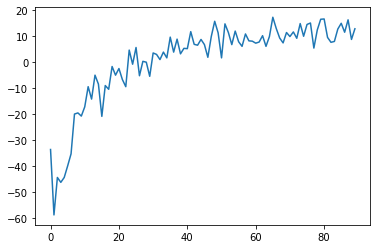

In [9]:
plt.plot(np.mean(msh, axis=0))